# Training of an autoencoder using a subset of the images

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg
import utils

/home/eugeniolr/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
noise_filter = True

## Reading and normalizing the images

In [3]:
# Read images
file_list = glob.glob("data/aia_193A/2016*.fits")

if noise_filter:
    noise_imgs = []
    with open("noisy_193A.csv", "r") as f:
        noise_imgs = f.readlines()
    
    noise_imgs = list(map(lambda x: x.strip(), noise_imgs))

    file_list = [f for f in file_list if f not in noise_imgs]

AIA193_2016 = sunpy.map.Map(file_list)

AIA193_2016_matrix = np.array(list(d.data for d in AIA193_2016))

AIA193_2016_mnorm = dg.AIA193Generator.normalize(AIA193_2016_matrix)

input_train, input_test = train_test_split(AIA193_2016_mnorm, test_size=0.25)

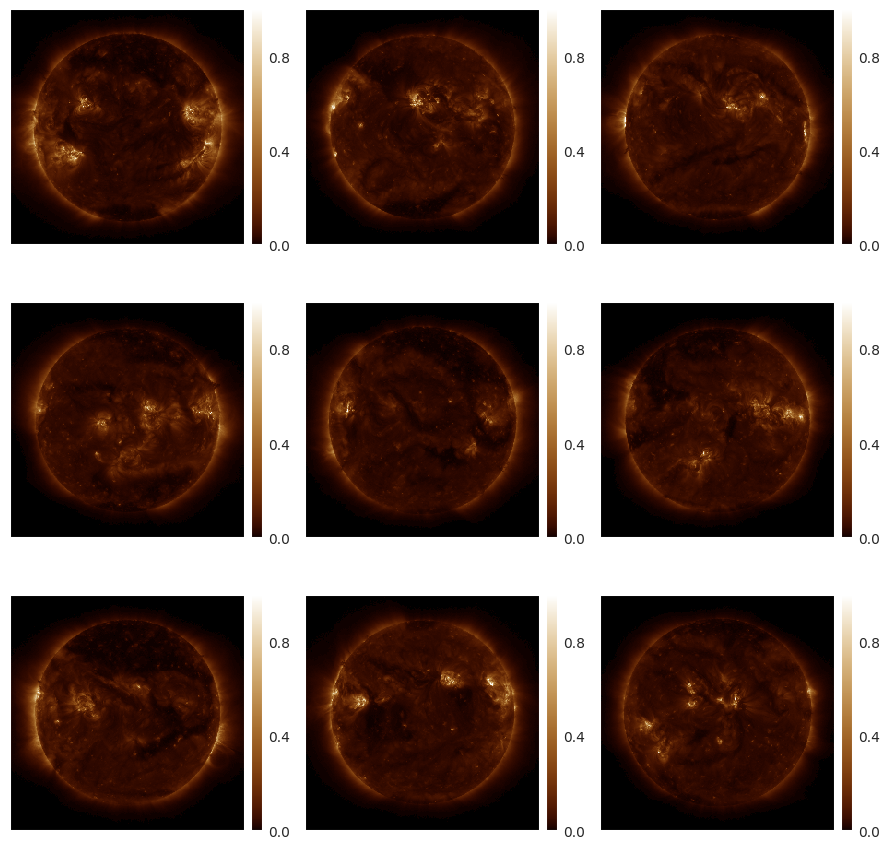

In [4]:
aia193_colormap = cm.color_tables.aia_color_table(193*u.angstrom)
isns.ImageGrid([i for i in AIA193_2016_mnorm[:9]], cmap=aia193_colormap, vmin=0, vmax=1)

## Training the model

In [5]:
latent_size = 64
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD()
# autoencoder, encoder, decoder = aem.gen_autoenc_model_1c(latent_size, optim=optimizer, loss="mse")
autoencoder, encoder, decoder = aem.gen_vae_model_1c(latent_size, optim=optimizer, loss="mse")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       80        
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      2320      
                                                             

In [6]:
n_epochs = 125
batch_size = 128

history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)

Epoch 1/125
14/14 [==============================] - 11s 195ms/step - loss: 0.0044 - mae: 0.0366 - val_loss: 0.0037 - val_mae: 0.0361
Epoch 2/125
14/14 [==============================] - 1s 65ms/step - loss: 0.0035 - mae: 0.0364 - val_loss: 0.0031 - val_mae: 0.0354
Epoch 3/125
14/14 [==============================] - 1s 65ms/step - loss: 0.0027 - mae: 0.0314 - val_loss: 0.0027 - val_mae: 0.0276
Epoch 4/125
14/14 [==============================] - 1s 68ms/step - loss: 0.0024 - mae: 0.0279 - val_loss: 0.0025 - val_mae: 0.0256
Epoch 5/125
14/14 [==============================] - 1s 70ms/step - loss: 0.0023 - mae: 0.0263 - val_loss: 0.0022 - val_mae: 0.0249
Epoch 6/125
14/14 [==============================] - 1s 70ms/step - loss: 0.0021 - mae: 0.0241 - val_loss: 0.0021 - val_mae: 0.0260
Epoch 7/125
14/14 [==============================] - 1s 71ms/step - loss: 0.0020 - mae: 0.0220 - val_loss: 0.0020 - val_mae: 0.0226
Epoch 8/125
14/14 [==============================] - 1s 71ms/step - loss: 

KeyboardInterrupt: 

## Evaluating the model

20/20 [==============================] - 1s 19ms/step - loss: 0.0153 - mae: 0.0723


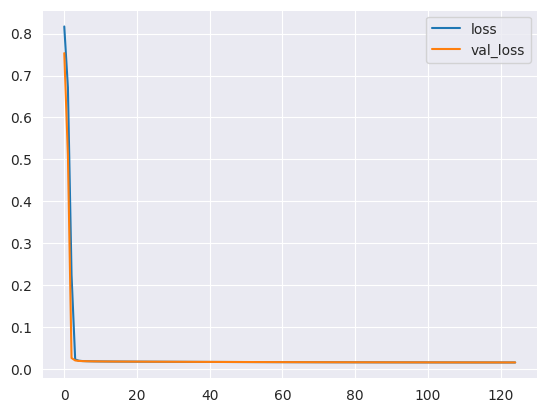

In [ ]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 110ms/step


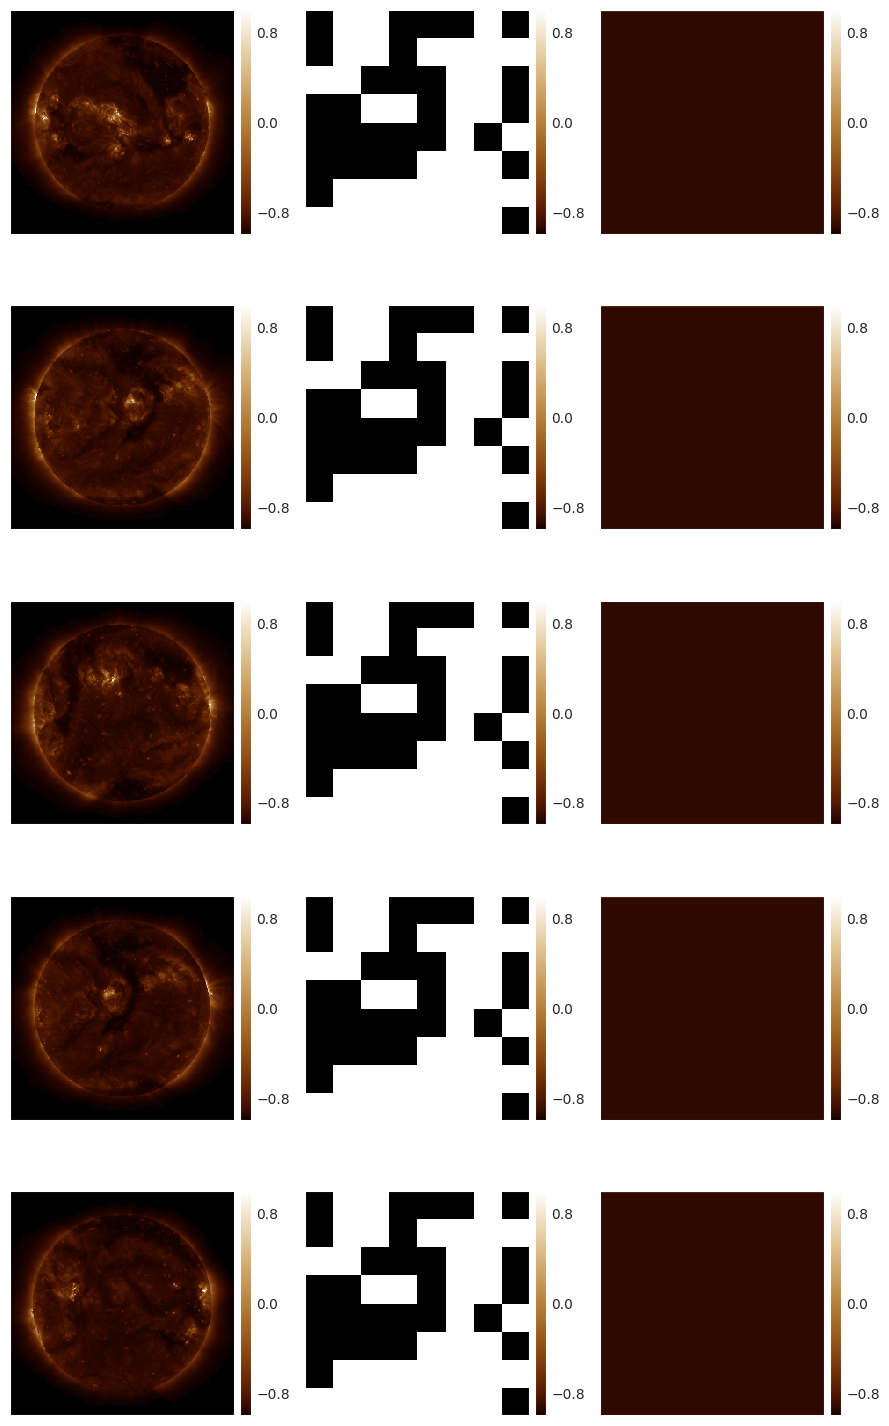

In [ ]:
idx = np.random.permutation(80)[:5]

example = input_test[idx]
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(utils.square_dims_vector(i[1]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=3)

1/1 [==============================] - 0s 8ms/step


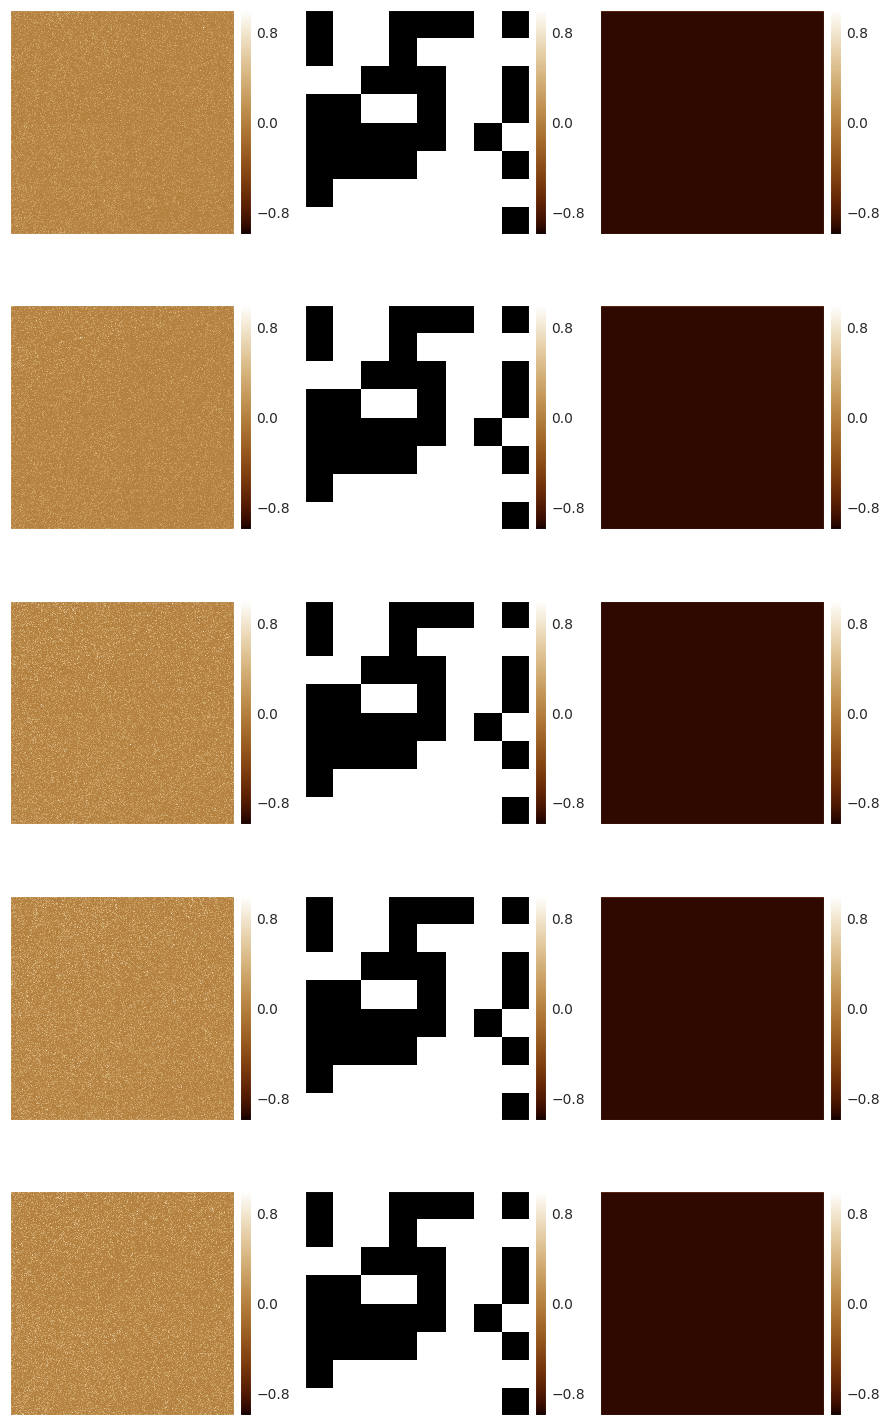

In [ ]:
# Read images
file_list = glob.glob("data/aia_193A/2016*.fits")

noisy_file_list = [f for f in file_list if f in noise_imgs]

AIA193_2016_noise = sunpy.map.Map(noisy_file_list)
AIA193_2016_matrix_noise = np.array(list(d.data for d in AIA193_2016_noise))

# Normalize images
AIA193_2016_matrix_noise = np.clip(AIA193_2016_matrix_noise, 0, 5000)
min_values = AIA193_2016_matrix_noise.min(axis=2, keepdims=True).min(axis=1, keepdims=True)
max_values = AIA193_2016_matrix_noise.max(axis=2, keepdims=True).max(axis=1, keepdims=True)

rg = max_values - min_values
rg = np.maximum(rg, 1e-4*np.ones(rg.shape)) # To avoid dividing by 0

AIA193_2016_mnorm_noise = (AIA193_2016_matrix_noise-min_values) / rg

idx = np.random.permutation(len(noisy_file_list))[:5]

example = AIA193_2016_mnorm_noise[idx]
code = encoder.predict(example)
reconstructed = decoder(code)

images_zipped = [i for i in zip(example, code, reconstructed)]
images = []

for i in images_zipped:
    images.append(np.squeeze(i[0]))
    images.append(utils.square_dims_vector(i[1]))
    images.append(np.squeeze(i[2]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=3)

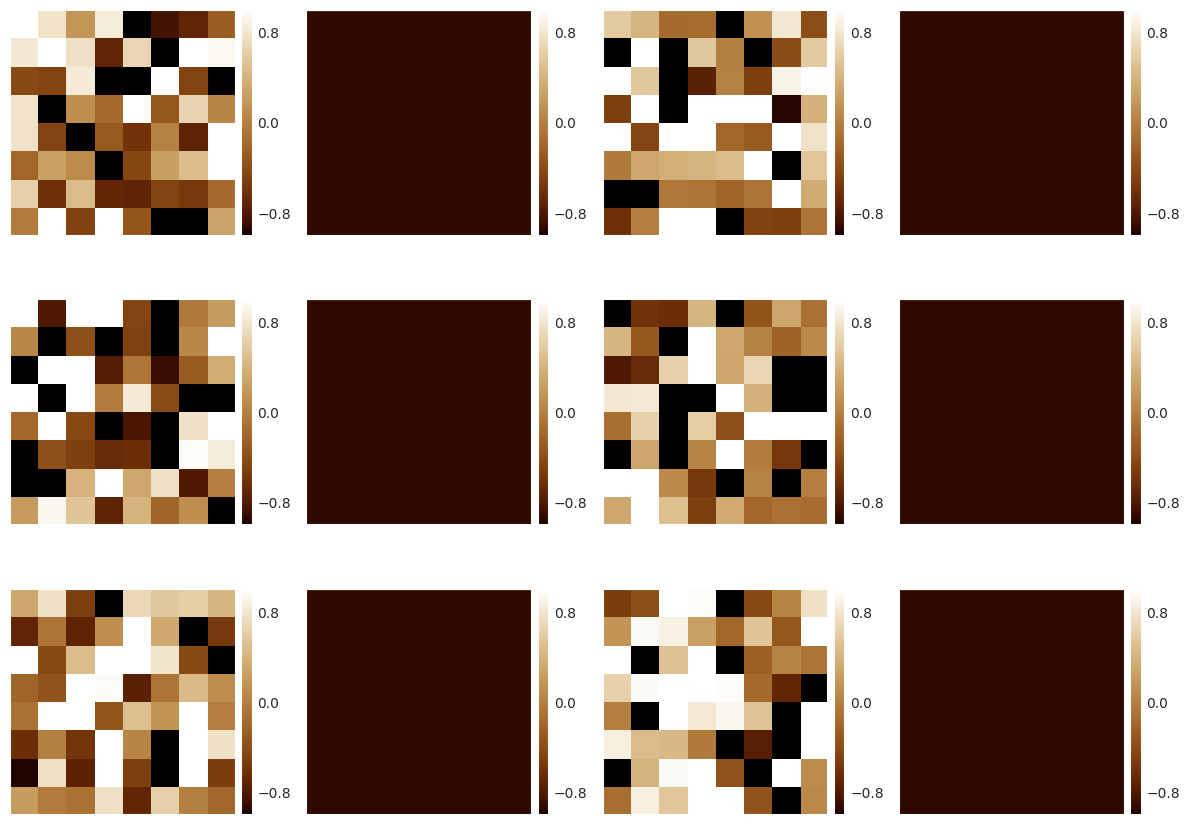

In [ ]:
code = np.random.normal(0, 1, [6, latent_size])
reconstructed = decoder(code)

images_zipped = [i for i in zip(code, reconstructed)]
images = []

for i in images_zipped:
    images.append(utils.square_dims_vector(i[0]))
    images.append(np.squeeze(i[1]))
    

isns.ImageGrid(images, cmap=aia193_colormap, vmin=0, vmax=1, col_wrap=4)